In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
data_path = '/mnt/data/cdiscount/'
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", data_path]).decode("utf8"))

test.bson
train.bson
train_example.bson



In [8]:
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
from scipy.misc import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data

In [10]:
# Simple data processing

data = bson.decode_file_iter(open(data_path + 'train_example.bson', 'rb'))

prod_to_category = dict()

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        # do something with the picture, etc

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [11]:
prod_to_category.head()

,category_id
_id,
0,1000010653
1,1000010653
2,1000004079
3,1000004141
4,1000015539


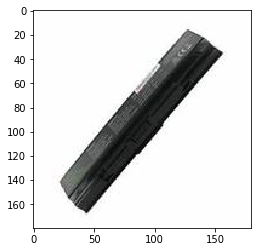

In [14]:
plt.imshow(picture)
plt.show()

In [15]:
NCORE =  8

prod_to_category = mp.Manager().dict() # note the difference

def process(q, iolock):
    while True:
        d = q.get()
        if d is None:
            break
        product_id = d['_id']
        category_id = d['category_id']
        prod_to_category[product_id] = category_id
        for e, pic in enumerate(d['imgs']):
            picture = imread(io.BytesIO(pic['picture']))
            # do something with the picture, etc
    
q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))

# process the file

data = bson.decode_file_iter(open(data_path + 'train.bson', 'rb'))
for c, d in enumerate(data):
    q.put(d)  # blocks until q below its max size

# tell workers we're done

for _ in range(NCORE):  
    q.put(None)
pool.close()
pool.join()

# convert back to normal dictionary
prod_to_category = dict(prod_to_category)

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

InvalidBSON: objsize too large

In [1]:
!ls /mnt/data/cdiscount

category_names.csv     test.bson   train_example.bson
sample_submission.csv  train.bson
